**Imports**

In [1]:
import copy
import itertools as it
import math

import simple_reactions_lib.core.core_classes as coreHelp
import simple_reactions_lib.core.core_units as unitHelp
import simple_reactions_lib.core.improved_controller as controllerHelp
import simple_reactions_lib.core.propagators as propagatorHelp

import simple_reactions_lib.standard.drive_reactions as reactDriver
import simple_reactions_lib.standard.my_mg_reactions_net_rates as mgReactHelp
import simple_reactions_lib.standard.damping_functions as dampHelp

import simple_reactions_lib.core.core_units as coreUnitsHelp


**Configuration variables**

In [2]:

#Barriers/Reaction energies taken from Wurger2020
VOLMER_BARRIER = 0.66
VOLMER_REACTION_ENERGY = -1.37

HEYROVSKY_BARRIER = 0.28
HEYROVSKY_REACTION_ENERGY = -1.07

TAFEL_BARRIER = 1.26
TAFEL_REACTION_ENERGY = 0.23

# water-assisted dissolution; based on some prelim calcs. I assume the Mg instantly goes from Mg(H2O)2 to Mg(H2O)6
WATER_ASSIST_DISSOL_BARRIER = 1.6
WATER_ASSIST_DISSOL_REACTION_ENERGY = -2.0 #Just a value i made up. Settting it super low just assumes the reaction never goes in reverse

#OH-assisted Dissolution; totally made up by me
OH_ASSIST_DISSOL_BARRIER = 1.6
OH_ASSIST_DISSOL_REACTION_ENERGY = -2.0 #Again, totally made up

#Barrier from references within Jiang2010 (0.53 is actually the given barrier)
#The reaction energy is estimated from Wang2017; though setting this such that its forward only is likely
#sensible in reality
H_DIFFUSION_BARRIER = 0.53
H_DIFFUSION_REACTION_ENERGY = 0.15


#Enthalpy is estimated using the arguments Taylor uses to get the BARRIER
#The barrier is estimate as the enthalpy + water-desorption energy (energy to pull the water into the GP)
OH_CATH_DESORP_BARRIER = 0.9 + 0.4
OH_CATH_DESORP_REACTION_ENERGY = 0.9


#Prefactor simply the (k_b T)/h factor in transition state theory
PLANCKS_CONSTANT_EV = 4.135667696e-15
PREFACTOR_STD = (coreUnitsHelp.BOLTZ_EV*300) / PLANCKS_CONSTANT_EV
SYM_FACTOR_STD = 0.5 #Default arg anyway so....

#General reaction conditions
START_POTENTIAL = 0
PH_VALUE = 7
TEMPERATURE = 300

#Starting concentrations (assume activity=concentration)
H2_FIXED_CONC = 1e-5 #Just a generic low value
MG_2PLUS_CONC = 2e-5 #Taylor2016 uses this
H_DIFFUSED_CONC = 1e-5 #Just a generic low value; should stop reverse reaction


In [3]:
"{:.5g}".format(PREFACTOR_STD)

'6.251e+12'

**Get H+/OH- concentrations from pH**

In [4]:
def _getHPlusAndOHMinusConcsFromPH(pHValue):
    hPlusConc = 10**(-1*pHValue)
    ohConc = 1e-14 / hPlusConc
    return hPlusConc, ohConc


protonConc, ohConc = _getHPlusAndOHMinusConcsFromPH(PH_VALUE)

**Get starting concentrations**

In [5]:
freeMg = coreHelp.ChemSpeciesStd("free"  , 1.0)
hAds   = coreHelp.ChemSpeciesStd("h_ads" , 0.0)
ohAds  = coreHelp.ChemSpeciesStd("oh_ads", 0.0)
fixedMgTwoPlus = coreHelp.ChemSpeciesStd("mg2+", MG_2PLUS_CONC)
fixedH2 = coreHelp.ChemSpeciesStd("h2",H2_FIXED_CONC)
fixedHDiffused = coreHelp.ChemSpeciesStd("h_diffused",H_DIFFUSED_CONC)
fixedProton = coreHelp.ChemSpeciesStd("h+",protonConc)
fixedOH = coreHelp.ChemSpeciesStd("oh-",ohConc)

startReactants = [freeMg, hAds, ohAds, fixedMgTwoPlus, fixedProton, fixedOH, fixedH2, fixedHDiffused]
# fixedConcReactants = [fixedMgTwoPlus, fixedProton, fixedOH, fixedH2, fixedHDiffused]
variableConcReactants = [freeMg, hAds, ohAds]
variableConcReactants = ["free", "h_ads", "oh_ads"]

**Setup all the reactions**

In [6]:
TAFEL_REACTION = mgReactHelp.TafelReactionNet(TAFEL_BARRIER, PREFACTOR_STD, TAFEL_REACTION_ENERGY)

HEYROV_REACTION = mgReactHelp.Heyrovsky_waterAssistedNet(HEYROVSKY_BARRIER, PREFACTOR_STD,
                                                         HEYROVSKY_REACTION_ENERGY, symFactorForward=SYM_FACTOR_STD)

VOLMER_REACTION = mgReactHelp.VolmerReactionNet(VOLMER_BARRIER, PREFACTOR_STD, VOLMER_REACTION_ENERGY)

H_DIFFUSE_REACTION = mgReactHelp.HydrogenBulkDiffusionNet(H_DIFFUSION_BARRIER, PREFACTOR_STD, H_DIFFUSION_REACTION_ENERGY)

OH_ASSIST_DISSOL = mgReactHelp.OHAssistedDissolutionReaction_twoElectronXferNet(OH_ASSIST_DISSOL_BARRIER, PREFACTOR_STD,
                                                             OH_ASSIST_DISSOL_REACTION_ENERGY,
                                                             symFactorForward=SYM_FACTOR_STD)

WATER_ASSIST_DISSOL = mgReactHelp.WaterAssistReaction_twoElectronXferNet(WATER_ASSIST_DISSOL_BARRIER, PREFACTOR_STD,
                                                                        WATER_ASSIST_DISSOL_REACTION_ENERGY,
                                                                        symFactorForward=SYM_FACTOR_STD)

OH_DESORPT = mgReactHelp.CathodicOHDesorption(OH_CATH_DESORP_BARRIER, PREFACTOR_STD, OH_CATH_DESORP_REACTION_ENERGY,
                                              symFactorForward=SYM_FACTOR_STD)



In [7]:
REACTIONS = [TAFEL_REACTION, HEYROV_REACTION, VOLMER_REACTION,
             OH_ASSIST_DISSOL, WATER_ASSIST_DISSOL, H_DIFFUSE_REACTION, OH_DESORPT]



In [8]:
dampHelp.TanhMinConcentrationDampingFunctStandard?

**Create the propagtor**

In [9]:
#Note that Euler/Runge-Kutta are generally pretty unstable when volmer/heyrovsky are mixed
ratesCalculator = controllerHelp.RateCalculatorStandard(REACTIONS)
concChangesFinder = controllerHelp.ConcChangesFinderStandard(ratesCalculator, variableConcReactants, maxConcChange=0.1)
propagator = controllerHelp.ConcsPropagatorStandard(concChangesFinder)
propagator = propagatorHelp.ConcsPropagator_DOP853(ratesCalculator, variableConcReactants, aTol=1e-2, rTol=0.1)
propagator = propagatorHelp.ConcsPropagator_Radau(ratesCalculator, variableConcReactants)



**Create the reaction controller**

In [10]:
CONTROLLER = controllerHelp.ReactionControllerImproved(propagator, startReactants,
                                                       temperature=TEMPERATURE, potential=START_POTENTIAL)

In [11]:
CONTROLLER.reset()
stepSize = 0.01
nSteps = 5000
nSteps = 150
outData = list()
currTime = 0

def _getReactantConcsFromController(controller):
    species = ["free", "h_ads", "oh_ads"]
    outConcs = list()
    for specie in species:
        currConc = [x.conc for x in controller.currentReactants if x.name==specie][0]
        outConcs.append(currConc)
    return outConcs

def _printReactantRatesFromController(controller):
    species = ["free", "h_ads", "oh_ads"]
    rateDict = ratesCalculator.getRates(CONTROLLER.currentReactants, temperature=CONTROLLER.temperature, potential=CONTROLLER.potential)
    [print(key,val) for key,val in sorted(rateDict.items()) if key in species]


#ODD BEHAVIOR: This becomes super slow as we appraoch the steady state; thats ~ the opposite to what i'd expect

outData =  [ [currTime] + _getReactantConcsFromController(CONTROLLER) ]
for n in range(nSteps):
    CONTROLLER.moveForwardByT(stepSize)
    currTime += stepSize
    currData = [ [currTime] + _getReactantConcsFromController(CONTROLLER) ]
    outData.extend(currData)


In [12]:
[str(x) for x in CONTROLLER.currentReactants]

['ChemSpeciesStd: free conc=0.0117',
 'ChemSpeciesStd: h_ads conc=2.51e-09',
 'ChemSpeciesStd: oh_ads conc=0.988',
 'ChemSpeciesStd: mg2+ conc=2e-05',
 'ChemSpeciesStd: h+ conc=1e-07',
 'ChemSpeciesStd: oh- conc=1e-07',
 'ChemSpeciesStd: h2 conc=1e-05',
 'ChemSpeciesStd: h_diffused conc=1e-05']

**Look at convergence for the simple case**

In [13]:
import gen_basis_helpers.shared.data_plot_base as dPlotHelp
currKwargs = {"xlabel": "Time", "ylabel": "Activity", "lineMarkers":["x"]}
timeVsConcsPlotter = dPlotHelp.DataPlotterStandard(**currKwargs)

In [14]:
plotData = list()
nReactants = len(outData[0][1:])
for idx in range(1, nReactants+1):
    currSeries = [ [x[0],x[idx]] for x in outData]
    plotData.append(currSeries)

In [15]:
outData[1][1:]

[0.6611492387454136, 3.1880810591427073e-07, 0.3388504424459676]

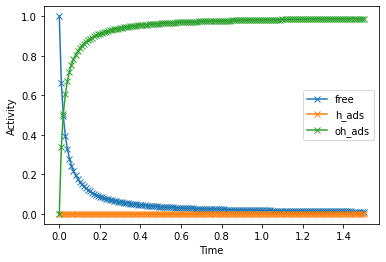

In [16]:
currPlot = timeVsConcsPlotter.createPlot(plotData, dataLabels=variableConcReactants, legend=True)

In [17]:
finalRates = ratesCalculator.getRates(CONTROLLER.currentReactants)
convParams = [ [key, finalRates[key]] for key  in finalRates.keys() if key in variableConcReactants]
convParams

[['h_ads', -1.8373641497149151e-09],
 ['free', -0.008451798920378964],
 ['oh_ads', 0.008451800757743148]]

**Look at surface species as a function of potential (fixed pH)**

In [18]:
timeStep = 200 #Just need to pick a value we'll ~ defo converge at
potentials = [-1.5,-1.0, -0.5, 0.0, 0.5, 1.0,1.5]


In [19]:


hAdsConcs, ohAdsConcs, freeAdsConcs = list(), list(), list()
allRates = list()
initReactants = copy.deepcopy(startReactants)
for pot in potentials:
    #Propagate to really far in the future
    CONTROLLER.reset()
    CONTROLLER.potential = pot
    CONTROLLER.moveForwardByT(timeStep)
    
    #Get rough values of 
    free, h_ads, oh_ads = _getReactantConcsFromController(CONTROLLER)
    currRates = ratesCalculator.getRates(CONTROLLER.currentReactants, temperature=CONTROLLER.temperature, potential=CONTROLLER.potential)
    allRates.append(currRates)
    hAdsConcs.append(h_ads)
    ohAdsConcs.append(oh_ads)
    freeAdsConcs.append(free)
    
    


**Plot the expected surface coverage vs potential (pH being fixed)**

In [20]:
import gen_basis_helpers.shared.data_plot_base as dPlotHelp

In [21]:

plotData = list()
dataLabels = ["free", "h_ads", "oh_ads"]
dataVals = [freeAdsConcs, hAdsConcs, ohAdsConcs]

for data in dataVals:
    currPlotData = list()
    for pot,conc in it.zip_longest(potentials,data):
        currPlotData.append(  [pot,conc] )
    plotData.append(currPlotData)






In [22]:
currKwargs = {"legend":True, "lineMarkers":["x"], "xlabel":"Potential (Vs PZC)", "ylabel":"Concentration"}
currPlotter = dPlotHelp.DataPlotterStandard(**currKwargs)
currPlotter.registeredKwargs

{'axHandle',
 'data',
 'dataLabels',
 'fontSizeAll',
 'legend',
 'lineColors',
 'lineMarkerSizes',
 'lineMarkers',
 'lineStyles',
 'mapPlotDataFunct',
 'plotFunct',
 'removeXTicks',
 'removeYTicks',
 'show',
 'showTitle',
 'titleStr',
 'xLim',
 'xTickLabelRotation',
 'xTickLabels',
 'xTickValues',
 'xlabel',
 'yLim',
 'ylabel'}

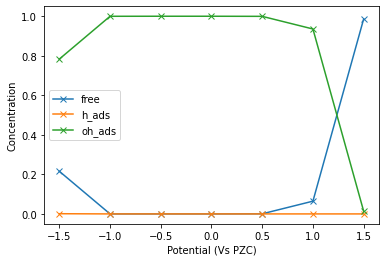

In [23]:
currPlot = currPlotter.createPlot(plotData, dataLabels=dataLabels)

**Plot the rates of change for the surface species; this is a convergence check**

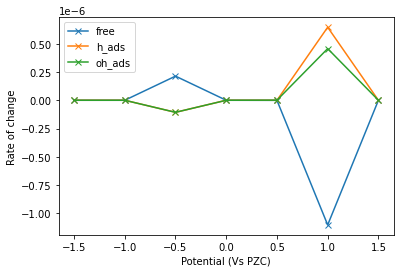

In [24]:
def _getRatesPlotDataForSpecies(inpSpecies, potentials, allRates):
    plotData = list()
    for spec in inpSpecies:
        currData = _getRatesPlotDataForSingleSpecies(spec, potentials, allRates)
        plotData.append(currData)
    return plotData


def _getRatesPlotDataForSingleSpecies(specie, potentials, allRates):
    outData = list()
    for pot,rates in it.zip_longest(potentials, allRates):
        currRate = rates[specie]
        outData.append( [pot,currRate]  )
    return outData

plotData = list()

#Input
inpSpecies = ["free", "h_ads", "oh_ads"]
potentials = potentials
allRates = allRates

#Function
plotData = list()
rateData = _getRatesPlotDataForSpecies(inpSpecies, potentials, allRates) 

currPlot = currPlotter.createPlot(rateData, dataLabels=inpSpecies, ylabel="Rate of change")

**Plot some steady-state rates vs potential**

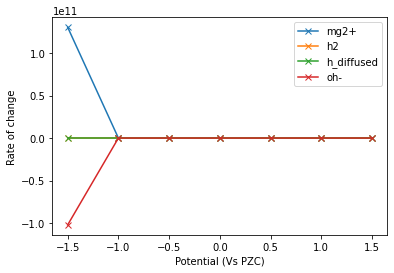

In [25]:
inpSpecies = ["mg2+", "h2", "h_diffused", "oh-"]
rateData = _getRatesPlotDataForSpecies(inpSpecies, potentials, allRates)
currPlot = currPlotter.createPlot(rateData, dataLabels=inpSpecies, ylabel="Rate of change")

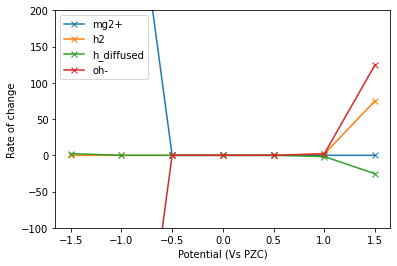

In [26]:
currPlot = currPlotter.createPlot(rateData, dataLabels=inpSpecies, ylabel="Rate of change", yLim=[-1e2,2e2])